# Train classifiers

This notebook will use the training dataset created by notebook `00c` to train the PU and SVM models.

If training data has been extracted from the source datasets by running the `00c-extract_training_data_global.ipynb` and `00b-extract_grid_data.ipynb` notebooks, set the `use_extracted_data` variable below to `True` to use this dataset instead of the pre-prepared training data from the [Zenodo repository](https://zenodo.org/record/8157691).

## Notebook options

These cells set some of the important variables and definitions used throughout the notebook.

In [1]:
# If True, use training data extracted in notebook 00c
# Else, use pre-prepared training data downloaded from Zenodo
use_extracted_data = True

# Random seed for reproducibility
random_seed = 1234

# Number of processes to use
n_jobs = 4

# Overwrite any existing output files
overwrite = True

# Control verbosity level of logging output
verbose = False

These values will usually not need to be modified:

In [2]:
import os

from lib.check_files import check_prepared_data

if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = check_prepared_data("prepared_data", verbose=True)

output_dir = "outputs"

If any of the following exist as environment variables, they will replace the values defined above:

In [3]:
random_seed = int(os.environ.get("RANDOM_SEED", random_seed))
n_jobs = int(os.environ.get("N_JOBS", n_jobs))
overwrite = bool(int(os.environ.get("OVERWRITE", overwrite)))
verbose = bool(int(os.environ.get("VERBOSE", verbose)))
output_dir = os.environ.get("OUTPUT_DIR", output_dir)

## Notebook setup

Imports, definitions, etc.

### Imports

In [4]:
import time
import warnings
from datetime import timedelta

import cartopy.crs as ccrs
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cartopy.mpl.gridliner import (
    LATITUDE_FORMATTER,
    LONGITUDE_FORMATTER,
)
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from pulearn.bagging import BaggingPuClassifier
from sklearn.base import clone
from sklearn.cluster import FeatureAgglomeration
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import IterativeImputer
from sklearn.model_selection import (
    GridSearchCV,
    RepeatedStratifiedKFold,
)
from sklearn.pipeline import (
    Pipeline,
    make_pipeline,
)
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC

from lib.check_files import check_prepared_data
from lib.feature_selection import (
    dendrogram_from_model,
    distance_threshold_from_model,
)
from lib.misc import (
    format_feature_name,
)
from lib.pu import (
    PU_PARAMS,
    COLUMNS_TO_DROP,
    PRESERVATION_COLUMNS,
    Scorer,
    downsample_unlabelled,
)

# Suppress FutureWarning for some versions of Scikit-learn
%env PYTHONWARNINGS=ignore::FutureWarning

warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", ConvergenceWarning)

env: PYTHONWARNINGS=ignore::FutureWarning


### Input and output files

In [5]:
data_filename = os.path.join(data_dir, "training_data_global.csv")

output_dir = os.path.join("outputs_new", "global")
os.makedirs(output_dir, exist_ok=True)
output_deposits = os.path.join(output_dir, "deposits.png")

pu_dir = os.path.join(output_dir, "PU")
os.makedirs(pu_dir, exist_ok=True)
pu_cv_basename = os.path.join(pu_dir, "cv_results")
pu_basename = os.path.join(pu_dir, "classifier")
pu_figures_dir = os.path.join(pu_dir, "feature_agglomeration")
os.makedirs(pu_figures_dir, exist_ok=True)

svm_dir = os.path.join(output_dir, "SVM")
os.makedirs(svm_dir, exist_ok=True)
svm_cv_basename = os.path.join(svm_dir, "cv_results")
svm_basename = os.path.join(svm_dir, "classifier")
svm_figures_dir = os.path.join(svm_dir, "feature_agglomeration")
os.makedirs(svm_figures_dir, exist_ok=True)

### Model parameters

In [6]:
# Parameters for models
imputer_params = {
    "random_state": random_seed,
    "add_indicator": False,
}
agg_params = {
    "n_clusters": None,  # placeholder, determined later
    "distance_threshold": None,  # placeholder, determined later
    "compute_distances": True,
}
rf_params = {
    "random_state": random_seed,
    "n_estimators": 50,
    "n_jobs": 1,
}
pu_params = {
    **PU_PARAMS,
    "n_jobs": n_jobs,
    "random_state": random_seed,
    "n_estimators": 50,
}
svm_params = {
    "kernel": "rbf",
    "probability": True,
    "random_state": random_seed,
}

# Options for cross-validation, parameter search
cv_params = {
    "n_splits": 5,
    "n_repeats": 5,
    "random_state": random_seed,
}
param_grid = {
    "featureagglomeration__n_clusters": [
        5,
        8,
        10,
        12,
        15,
        18,
        20,
        22,
        25,
        28,
        30,
        35,
        40,
    ],
}

Define model preprocessing:

In [7]:
# Impute missing values, scale, and combine features
preprocessing = make_pipeline(
    IterativeImputer(**imputer_params),
    RobustScaler(),
    VarianceThreshold(),
    FeatureAgglomeration(**agg_params),
)
cv = RepeatedStratifiedKFold(**cv_params)
scoring = Scorer.adjusted_recall_auc_score

## Training data

These cells load and plot the training data.

In [8]:
data = pd.read_csv(data_filename)

# Skip regions with < 50 deposits
regions_to_skip = set()
for region, subset in data.groupby("region"):
    if (subset["label"] == "positive").sum() < 50:
        regions_to_skip.add(region)
data = data[~data["region"].isin(regions_to_skip)]

# Equal number of positive and unlabelled samples
negatives = data[data["label"] == "negative"]
tmp = data[data["label"] != "negative"]
tmp_downsampled = downsample_unlabelled(
    tmp,
    random_state=random_seed,
)
combined = pd.concat((tmp_downsampled, negatives))
cleaned = combined.drop(
    columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS),
    errors="ignore",
)
del tmp, tmp_downsampled

print("Training data summary:")
print(combined.groupby(["region", "label"]).size())

Training data summary:
region          label     
North America   negative       56
                positive      308
                unlabelled    134
South America   negative      702
                positive      236
                unlabelled    132
Southeast Asia  negative        4
                positive       57
                unlabelled    200
Tethys          positive       75
                unlabelled    210
dtype: int64


### Deposit locations plot

This cell plots the locations of the deposits in the training dataset, saving the image in the `output_dir` directory.

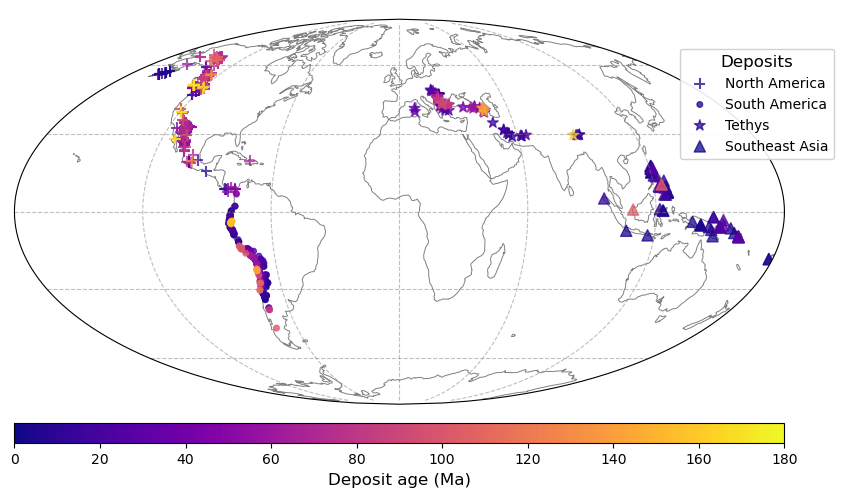

In [9]:
deposits = data[data["label"] == "positive"]

projection = ccrs.Mollweide()
transform = ccrs.PlateCarree()

markers = {
    "North America": "+",
    "South America": ".",
    "Tethys": "*",
    "Southeast Asia": "^",
}
vmin, vmax = 0, 180
cmap = "plasma"
mappable = ScalarMappable(Normalize(vmin, vmax), cmap=cmap)

fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw={"projection": projection},
)
ax.set_global()
gl = ax.gridlines(
    draw_labels=False,
    xformatter=LONGITUDE_FORMATTER,
    yformatter=LATITUDE_FORMATTER,
    linestyle="dashed",
    linewidth=0.8,
    alpha=0.5,
    color="grey",
)
cax = fig.add_axes(
    [
        ax.get_position().x0,
        ax.get_position().y0 * 0.3,
        ax.get_position().width,
        ax.get_position().height * 0.05,
    ]
)
for region, marker in markers.items():
    subset = deposits[deposits["region"] == region]
    scat = ax.scatter(
        "present_lon",
        "present_lat",
        c="age (Ma)",
        data=subset,
        marker=marker,
        s=65,
        alpha=0.75,
        transform=transform,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        zorder=1,
        label=region,
    )
ax.coastlines(zorder=0, color="grey", linewidth=0.7)
cbar = fig.colorbar(
    mappable,
    cax=cax,
    orientation="horizontal",
)
cbar.ax.set_xlabel("Deposit age (Ma)", fontsize=12)
cbar.ax.tick_params(labelsize=10)
fig.legend(
    title="Deposits",
    loc=(0.8, 0.68),
    framealpha=0.9,
    fontsize=10,
    title_fontsize=12,
)
fig.savefig(output_deposits, dpi=400, bbox_inches="tight")

## Train the PU models

In the following cells, the positive-unlabelled models are created and trained.

### Global dataset

#### Perform cross-validation and plot results

Here we use cross-validation to select an appropriate value for the number of input features for the model.

In [10]:
# Perform cross-validation for model hyperparameter selection

# Wrangle the training data to the required format
train_pu = cleaned[cleaned["label"].isin({"positive", "unlabelled"})]
x_pu = train_pu.drop(columns="label")
y_pu = train_pu["label"].replace({"positive": 1, "unlabelled": 0})

if overwrite or not os.path.isfile(pu_cv_basename + ".joblib"):
    pu_model = BaggingPuClassifier(
        RandomForestClassifier(**rf_params),
        **pu_params,
    )
    pu_pipeline = make_pipeline(
        *(clone(preprocessing)),
        pu_model,
    )
    pu_pipeline.set_output(transform="pandas")
    pu_search = GridSearchCV(
        pu_pipeline,
        param_grid=param_grid,
        n_jobs=max((n_jobs // 4, 1)),
        refit=True,
        cv=cv,
        verbose=verbose,
        scoring=scoring,
        return_train_score=False,
    )

    # Train model
    t0 = time.time()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FitFailedWarning)
        pu_search.fit(x_pu, y_pu)

    # Save to file
    joblib.dump(pu_search, pu_cv_basename + ".joblib", compress=True)
    duration = timedelta(seconds=time.time() - t0)
    print(f"Cross-validation time: {duration}")
else:
    pu_search = joblib.load(pu_cv_basename + ".joblib")

Cross-validation time: 0:17:40.083257


We use the qualitative "elbow" method to identify an appropriate choice for the parameter.
This plot will also be saved to the output directory.

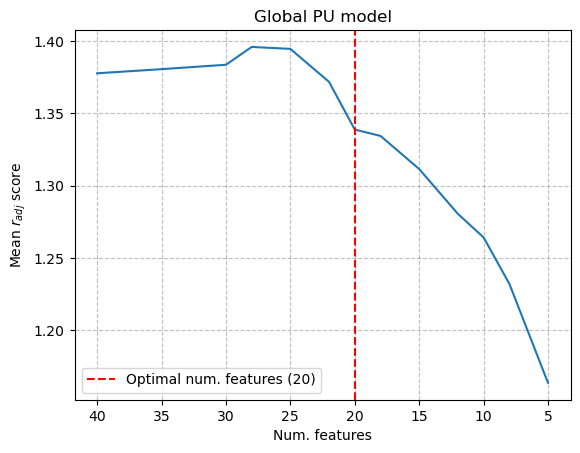

In [11]:
# Plot the results of the cross-validation performed
# in the previous cell

df_pu_search = pd.concat(
    (
        pd.DataFrame(pu_search.cv_results_["params"]),
        pd.DataFrame(
            {
                key: pu_search.cv_results_[key]
                for key in (
                    "mean_test_score",
                    "std_test_score",
                )
            }
        )
    ),
    axis="columns",
)
fig, ax = plt.subplots()
l = ax.plot(
    "featureagglomeration__n_clusters",
    "mean_test_score",
    data=df_pu_search,
    label=None,
)[0]
l.set_label(None)
ax.grid(
    linestyle="dashed",
    color="grey",
    alpha=0.5,
)
ax.set_xlim(*(ax.get_xlim()[::-1]))
ax.set_xlabel("Num. features")
ax.set_ylabel(r"Mean $r_{adj}$ score")
ax.set_title("Global PU model")

n_clusters_pu = 20
ax.axvline(
    n_clusters_pu,
    linestyle="dashed",
    color="red",
    label=f"Optimal num. features ({n_clusters_pu})",
)
ax.legend()
fig.savefig(
    os.path.join(pu_figures_dir, "cv_results.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Train model with chosen number of features

The model will be written to a `.joblib` file in the output directory.

In [12]:
if overwrite or (not os.path.isfile(pu_basename + ".joblib")):
    pu_best = clone(pu_search.best_estimator_)
    pu_best["featureagglomeration"].set_params(n_clusters=n_clusters_pu)
    pu_best.fit(x_pu, y_pu)
    joblib.dump(pu_best, pu_basename + ".joblib")
else:
    pu_best = joblib.load(pu_basename + ".joblib")

#### Dendrogram plot

This plot illustrates how highly correlated input features are merged using feature agglomeration.

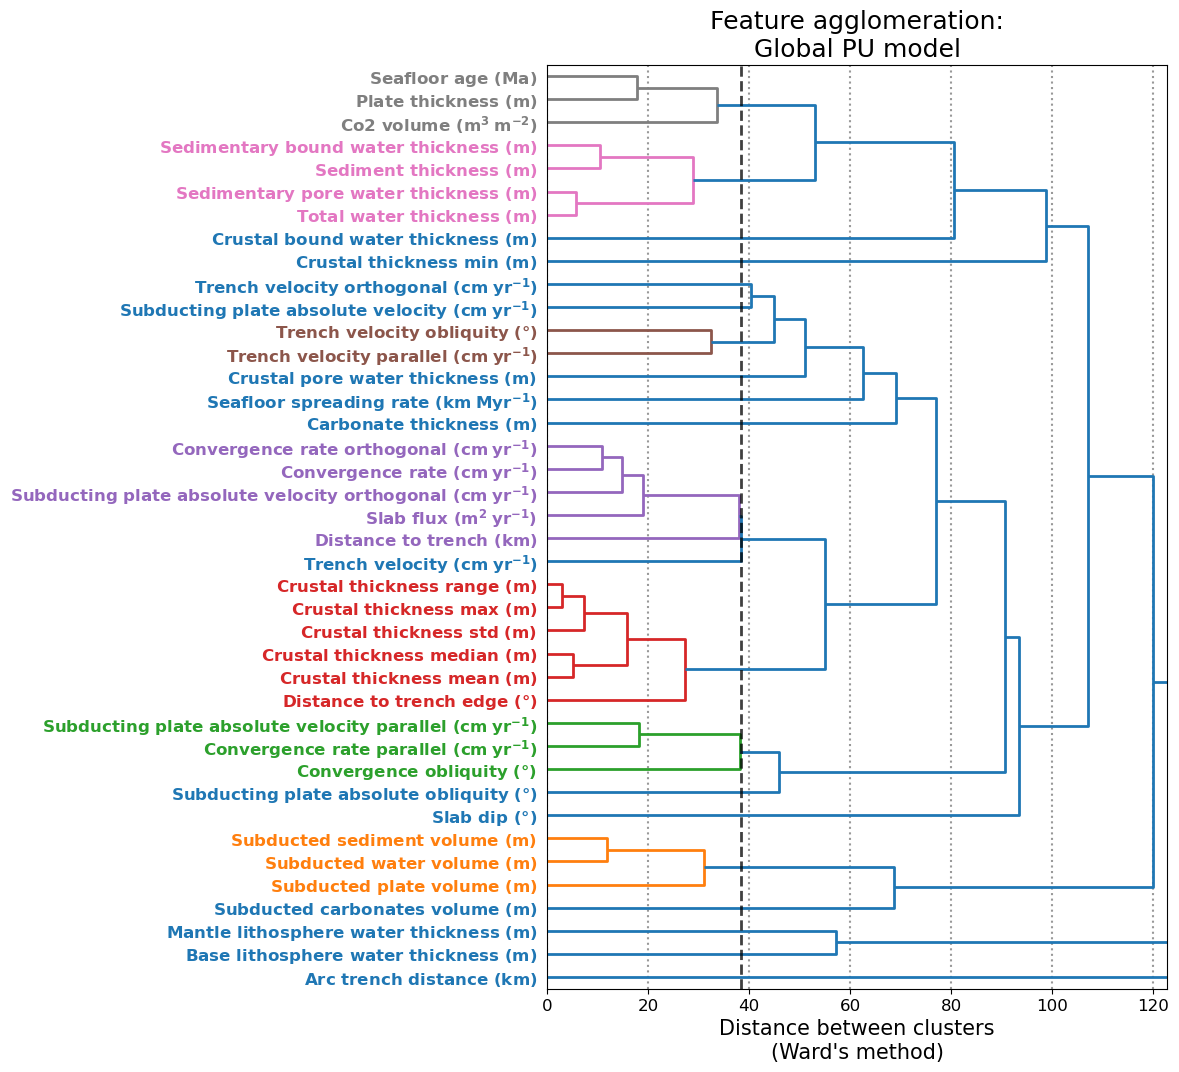

In [13]:
agg_pu = pu_best["featureagglomeration"]
dist_thresh_pu = agg_pu.distance_threshold
if dist_thresh_pu is None:
    dist_thresh_pu = distance_threshold_from_model(agg_pu)

fig, ax = plt.subplots(figsize=(8, 12))
dendro = dendrogram_from_model(
    agg_pu,
    orientation="right",
    color_threshold=dist_thresh_pu,
    labels=[format_feature_name(i, bold=True) for i in agg_pu.feature_names_in_],
).dendrogram
ax.set_xlim(0, np.quantile(agg_pu.distances_, 0.95))
ax.grid(
    linestyle="dotted",
    color="grey",
    alpha=0.8,
    linewidth=1.5,
    axis="x",
)
ax.axvline(
    dist_thresh_pu,
    linestyle="dashed",
    color="black",
    alpha=0.75,
    linewidth=2,
)
ax.tick_params(labelsize=12)
ax.set_title("Feature agglomeration:\nGlobal PU model", fontsize=18)
ax.set_xlabel("Distance between clusters\n(Ward's method)", fontsize=15)
for coll in ax.collections:
    coll.set_linewidth(2)
for i, j in zip(ax.get_ymajorticklabels(), dendro["leaves_color_list"]):
    i.set_color(j)
    i.set_fontweight("bold")
fig.savefig(
    os.path.join(pu_figures_dir, "dendrogram.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Merged features

For reference, the merged feature clusters are printed here.

In [14]:
df_clusters_pu = pd.DataFrame(
    {
        "cluster": agg_pu.labels_,
        "feature": agg_pu.feature_names_in_,
    }
)

print("Merged features:")
l = "-" * max([len(i) for i in df_clusters_pu["feature"]])
print(l)
for cluster, subset in df_clusters_pu.groupby("cluster"):
    if subset.shape[0] <= 1:
        continue
    for feature in sorted(subset["feature"]):
        print(feature)
    print(l)

Merged features:
-----------------------------------------------------
convergence_rate (cm/yr)
convergence_rate_orthogonal (cm/yr)
distance_to_trench (km)
slab_flux (m^2/yr)
subducting_plate_absolute_velocity_orthogonal (cm/yr)
trench_velocity (cm/yr)
-----------------------------------------------------
convergence_obliquity (degrees)
convergence_rate_parallel (cm/yr)
subducting_plate_absolute_velocity_parallel (cm/yr)
-----------------------------------------------------
co2_volume (m^3/m^2)
plate_thickness (m)
seafloor_age (Ma)
-----------------------------------------------------
trench_velocity_obliquity (degrees)
trench_velocity_parallel (cm/yr)
-----------------------------------------------------
subducted_plate_volume (m)
subducted_sediment_volume (m)
subducted_water_volume (m)
-----------------------------------------------------
crustal_thickness_max (m)
crustal_thickness_mean (m)
crustal_thickness_median (m)
crustal_thickness_range (m)
crustal_thickness_std (m)
distance_to

### Regional models

#### Perform cross-validation and plot results

Here we use cross-validation to select an appropriate value for the number of input features for the models.

In [15]:
pu_search_regions = {}
pu_best_regions = {}

for region, subset in combined.groupby("region"):
    region = str(region)
    if (subset["label"] == "positive").sum() < 50:
        print(f"Skipping region: {region}")
        continue
    subset = subset.drop(
        columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS),
        errors="ignore",
    )
    r = "_".join(region.lower().split())
    output_cv_subset = pu_cv_basename + f"_{r}.joblib"

    if (
        (not overwrite)
        and os.path.isfile(output_cv_subset)
    ):
        print(f"Loading from file: {region}")
        pu_search_regions[region] = joblib.load(output_cv_subset)
        continue

    print(f"Region: {region}")
    subset = subset[subset["label"].isin({"positive", "unlabelled"})]
    print(subset.groupby("label").size())
    x_pu_subset = subset.drop(columns="label")
    y_pu_subset = subset["label"].replace({"positive": 1, "unlabelled": 0})

    pu_search_subset = clone(pu_search)
    t0 = time.time()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FitFailedWarning)
        pu_search_subset.fit(x_pu_subset, y_pu_subset)
    joblib.dump(pu_search_subset, output_cv_subset, compress=True)
    pu_search_regions[region] = pu_search_subset
    duration = timedelta(seconds=time.time() - t0)
    print(f"Cross-validation time: {duration}")

    print("")

Region: North America
label
positive      308
unlabelled    134
dtype: int64


Cross-validation time: 0:10:20.359812

Region: South America
label
positive      236
unlabelled    132
dtype: int64


Cross-validation time: 0:10:02.229942

Region: Southeast Asia
label
positive       57
unlabelled    200
dtype: int64


 2.1649584  2.23407555 2.25196272 2.29347256 2.31587437 2.32555088
        nan]


Cross-validation time: 0:08:38.568285

Region: Tethys
label
positive       75
unlabelled    210
dtype: int64


Cross-validation time: 0:12:48.766680



As before, we will use the "elbow" method to select the number of merged features.

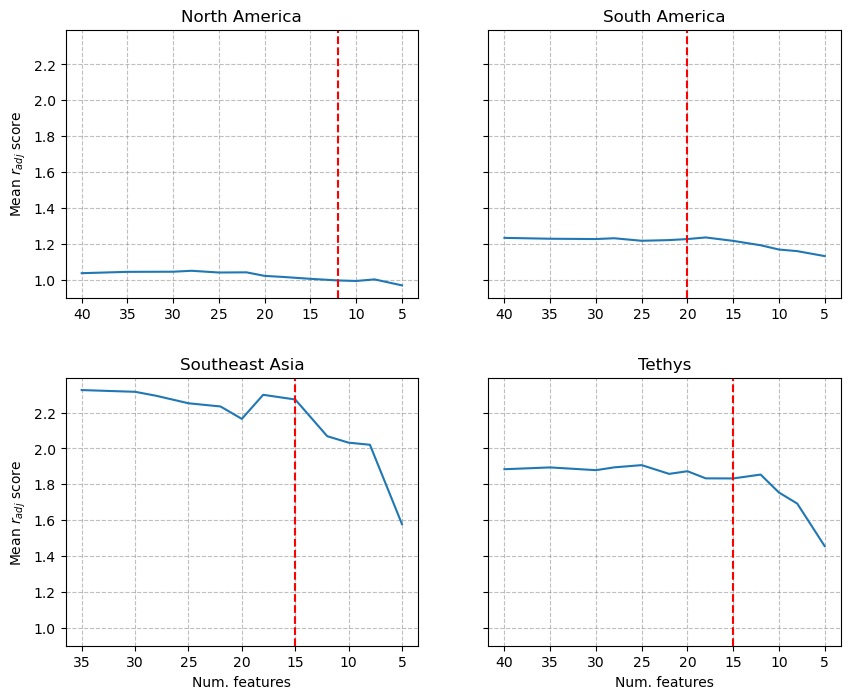

In [16]:
pu_axes = {}

fig, axs = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={"hspace": 0.3}, sharey=True)
for ax, (region, pu_search_subset) in zip(np.ravel(axs), pu_search_regions.items()):
    pu_axes[region] = ax
    df_pu_subset = pd.concat(
        (
            pd.DataFrame(pu_search_subset.cv_results_["params"]),
            pd.DataFrame(
                {
                    key: pu_search_subset.cv_results_[key]
                    for key in (
                        "mean_test_score",
                        "std_test_score",
                    )
                }
            )
        ),
        axis="columns",
    )
    l = ax.plot(
        "featureagglomeration__n_clusters",
        "mean_test_score",
        data=df_pu_subset,
    )[0]
    l.set_label(None)

    ax.grid(
        linestyle="dashed",
        color="grey",
        alpha=0.5,
    )
    ax.set_xlim(*(ax.get_xlim()[::-1]))
    ax.set_title(region)

n_clusters_pu_regions = {
    "North America": 12,
    "South America": 20,
    "Southeast Asia": 15,
    "Tethys": 15,
}
for region, n_clusters_region in n_clusters_pu_regions.items():
    ax = pu_axes[region]
    ax.axvline(
        n_clusters_region,
        linestyle="dashed",
        color="red",
        label="Optimal num. features",
    )

for ax in axs[:, 0]:
    ax.set_ylabel(r"Mean $r_{adj}$ score")
for ax in axs[-1, :]:
    ax.set_xlabel("Num. features")
fig.savefig(
    os.path.join(pu_figures_dir, "cv_results_regions.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Train models with chosen numbers of features

In [17]:
for region, n_clusters_region in n_clusters_pu_regions.items():
    r = "_".join(region.lower().split())
    output_subset = pu_basename + f"_{r}.joblib"

    if overwrite or (not os.path.isfile(output_subset)):
        subset_best = clone(pu_search_regions[region].best_estimator_)
        subset_best["featureagglomeration"].set_params(n_clusters=n_clusters_region)
        subset = combined[combined["region"] == region]
        subset = subset.drop(
            columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS),
            errors="ignore",
        )
        subset = subset[subset["label"].isin({"positive", "unlabelled"})]
        x_pu_subset = subset.drop(columns="label")
        y_pu_subset = subset["label"].replace({"positive": 1, "unlabelled": 0})
        subset_best.fit(x_pu_subset, y_pu_subset)
        pu_best_regions[region] = subset_best
        joblib.dump(subset_best, output_subset, compress=True)
    else:
        pu_best_regions[region] = joblib.load(output_subset)

#### Dendrogram plots

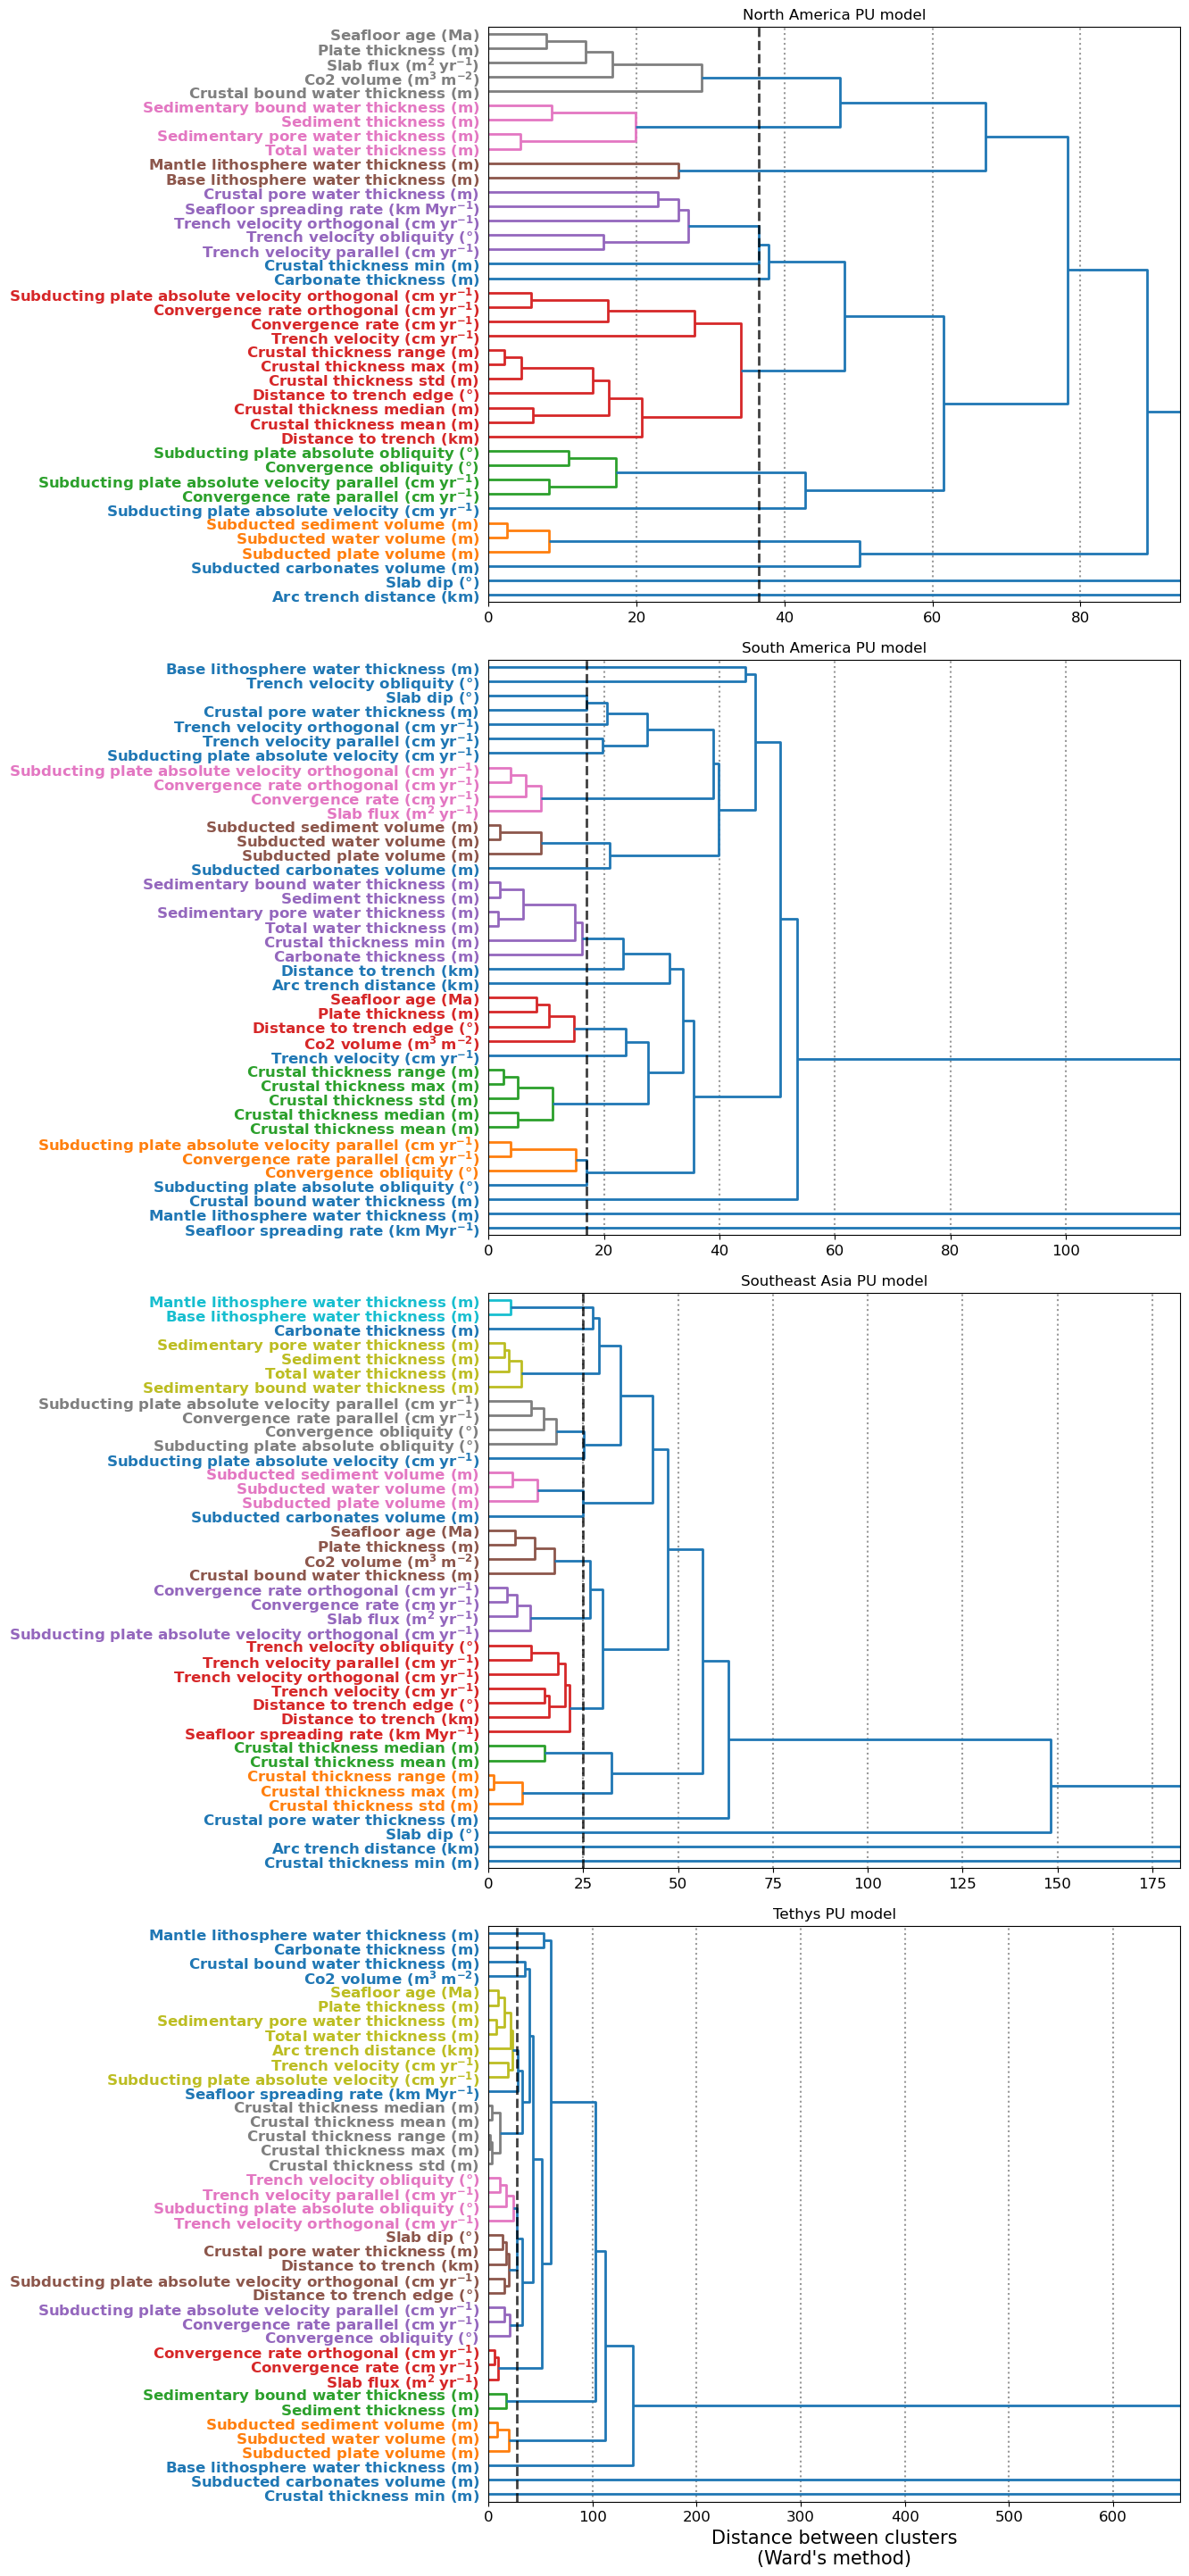

In [18]:
nrows = len(pu_best_regions)
fig, axs = plt.subplots(
    nrows,
    figsize=(10, 9 * nrows),
    gridspec_kw={"hspace": 0.1},
    squeeze=False,
)

for (region, pu_best_region), ax in zip(pu_best_regions.items(), np.ravel(axs)):
    agg_pu_region = pu_best_region["featureagglomeration"]
    dist_thresh_pu_region = agg_pu_region.distance_threshold
    if dist_thresh_pu_region is None:
        dist_thresh_pu_region = distance_threshold_from_model(agg_pu_region)

    dendro = dendrogram_from_model(
        agg_pu_region,
        orientation="right",
        color_threshold=dist_thresh_pu_region,
        ax=ax,
        labels=[format_feature_name(i, bold=True) for i in agg_pu_region.feature_names_in_],
    ).dendrogram
    ax.set_xlim(0, np.quantile(agg_pu_region.distances_, 0.95))
    ax.grid(
        linestyle="dotted",
        color="grey",
        alpha=0.8,
        linewidth=1.5,
        axis="x",
    )
    ax.axvline(
        dist_thresh_pu_region,
        linestyle="dashed",
        color="black",
        alpha=0.75,
        linewidth=2,
    )
    ax.tick_params(labelsize=12)
    ax.set_title(f"{region} PU model")
    for coll in ax.collections:
        coll.set_linewidth(2)
    for i, j in zip(ax.get_ymajorticklabels(), dendro["leaves_color_list"]):
        i.set_color(j)
        i.set_fontweight("bold")
for ax in axs[-1, :]:
    ax.set_xlabel("Distance between clusters\n(Ward's method)", fontsize=15)
fig.savefig(
    os.path.join(pu_figures_dir, "dendrograms_regions.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Merged features

In [19]:
for region, pu_best_region in pu_best_regions.items():
    agg_pu_region = pu_best_region["featureagglomeration"]
    df_clusters_region = pd.DataFrame(
        {
            "cluster": agg_pu_region.labels_,
            "feature": agg_pu_region.feature_names_in_,
        }
    )
    print(f"{region}:")
    print("Merged features:")
    l = "-" * max([len(i) for i in df_clusters_region["feature"]])
    print(l)
    for cluster, subset in df_clusters_region.groupby("cluster"):
        if subset.shape[0] <= 1:
            continue
        for feature in sorted(subset["feature"]):
            print(feature)
        print(l)
    print("\n")

North America:
Merged features:
-----------------------------------------------------
crustal_pore_water_thickness (m)
crustal_thickness_min (m)
seafloor_spreading_rate (km/Myr)
trench_velocity_obliquity (degrees)
trench_velocity_orthogonal (cm/yr)
trench_velocity_parallel (cm/yr)
-----------------------------------------------------
convergence_rate (cm/yr)
convergence_rate_orthogonal (cm/yr)
crustal_thickness_max (m)
crustal_thickness_mean (m)
crustal_thickness_median (m)
crustal_thickness_range (m)
crustal_thickness_std (m)
distance_to_trench (km)
distance_to_trench_edge (degrees)
subducting_plate_absolute_velocity_orthogonal (cm/yr)
trench_velocity (cm/yr)
-----------------------------------------------------
co2_volume (m^3/m^2)
crustal_bound_water_thickness (m)
plate_thickness (m)
seafloor_age (Ma)
slab_flux (m^2/yr)
-----------------------------------------------------
convergence_obliquity (degrees)
convergence_rate_parallel (cm/yr)
subducting_plate_absolute_obliquity (degrees)

## Train the SVM models

In the following cells, the supervised SVM models are created and trained.

N.B. These models are only created for the regions for which labelled negative data exists (i.e. North and South America).

### Global dataset

#### Perform cross-validation and plot results

In [20]:
# Wrangle training data
train_svm = cleaned[cleaned["label"].isin({"positive", "negative"})]
x_svm = train_svm.drop(columns="label")
y_svm = train_svm["label"].replace({"positive": 1, "negative": 0})

if overwrite or not os.path.isfile(svm_cv_basename + ".joblib"):
    svm_model = SVC(**svm_params)
    svm_pipeline = make_pipeline(
        *(clone(preprocessing)),
        svm_model,
    )
    svm_pipeline.set_output(transform="pandas")
    svm_search = GridSearchCV(
        svm_pipeline,
        param_grid=param_grid,
        n_jobs=n_jobs,
        refit=True,
        cv=cv,
        verbose=verbose,
        scoring="f1",
        return_train_score=False,
    )

    # Train model
    t0 = time.time()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FitFailedWarning)
        svm_search.fit(x_svm, y_svm)

    # Save to file
    joblib.dump(svm_search, svm_cv_basename + ".joblib", compress=True)
    duration = timedelta(seconds=time.time() - t0)
    print(f"Cross-validation time: {duration}")
else:
    svm_search = joblib.load(svm_cv_basename + ".joblib")

Cross-validation time: 0:00:38.460945


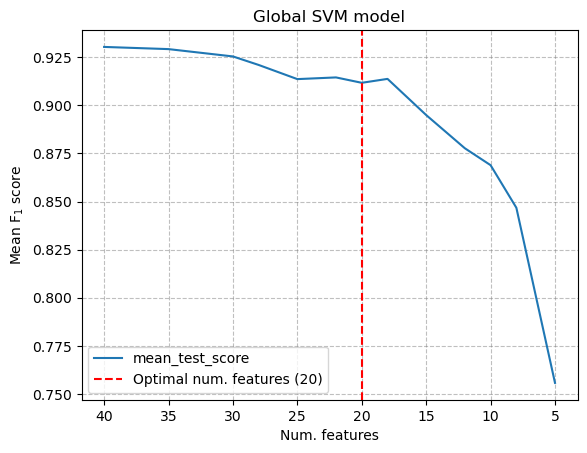

In [21]:
df_svm_search = pd.concat(
    (
        pd.DataFrame(svm_search.cv_results_["params"]),
        pd.DataFrame(
            {
                key: svm_search.cv_results_[key]
                for key in (
                    "mean_test_score",
                    "std_test_score",
                )
            }
        )
    ),
    axis="columns",
)
fig, ax = plt.subplots()
ax.plot(
    "featureagglomeration__n_clusters",
    "mean_test_score",
    data=df_svm_search,
)
ax.grid(
    linestyle="dashed",
    color="grey",
    alpha=0.5,
)
ax.set_xlim(*(ax.get_xlim()[::-1]))
ax.set_xlabel("Num. features")
ax.set_ylabel(r"Mean $\mathrm{F_1}$ score")
ax.set_title("Global SVM model")

n_clusters_svm = 20
ax.axvline(
    n_clusters_svm,
    linestyle="dashed",
    color="red",
    label=f"Optimal num. features ({n_clusters_svm})",
)
ax.legend()
fig.savefig(
    os.path.join(svm_figures_dir, "cv_results.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Train model with chosen number of features

In [22]:
if overwrite or (not os.path.isfile(svm_basename + ".joblib")):
    svm_best = clone(svm_search.best_estimator_)
    svm_best["featureagglomeration"].set_params(n_clusters=n_clusters_svm)
    svm_best.fit(x_svm, y_svm)
    joblib.dump(svm_best, svm_basename + ".joblib")
else:
    svm_best = joblib.load(svm_basename + ".joblib")

#### Dendrogram plot

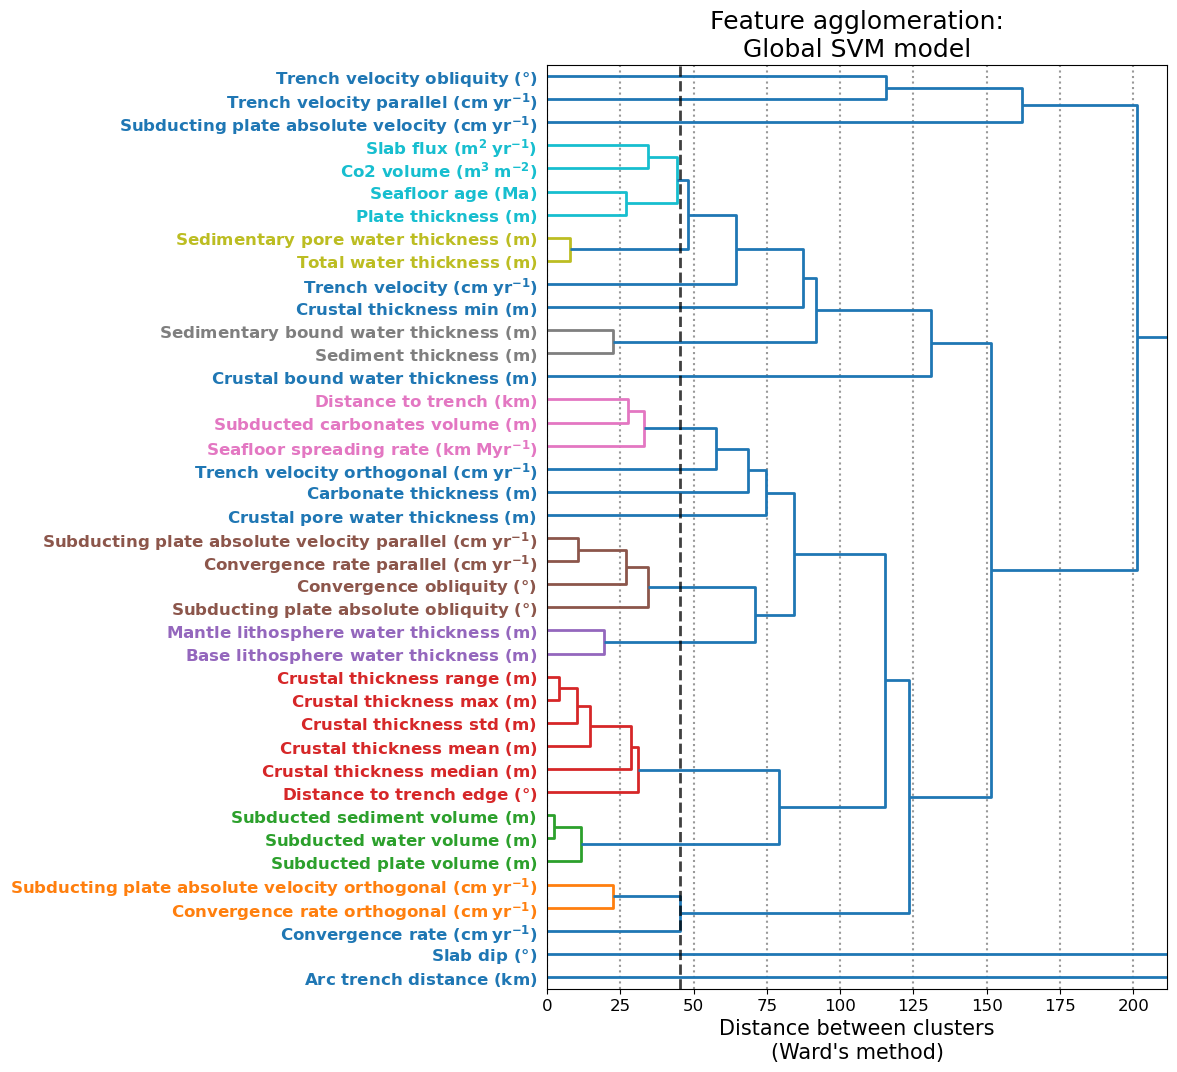

In [23]:
agg_svm = svm_best["featureagglomeration"]
dist_thresh_svm = agg_svm.distance_threshold
if dist_thresh_svm is None:
    dist_thresh_svm = distance_threshold_from_model(agg_svm)

fig, ax = plt.subplots(figsize=(8, 12))
dendro = dendrogram_from_model(
    agg_svm,
    orientation="right",
    color_threshold=dist_thresh_svm,
    labels=[format_feature_name(i, bold=True) for i in agg_svm.feature_names_in_],
).dendrogram
ax.set_xlim(0, np.quantile(agg_svm.distances_, 0.95))
ax.grid(
    linestyle="dotted",
    color="grey",
    alpha=0.8,
    linewidth=1.5,
    axis="x",
)
ax.axvline(
    dist_thresh_svm,
    linestyle="dashed",
    color="black",
    alpha=0.75,
    linewidth=2,
)
ax.tick_params(labelsize=12)
ax.set_title("Feature agglomeration:\nGlobal SVM model", fontsize=18)
ax.set_xlabel("Distance between clusters\n(Ward's method)", fontsize=15)
for coll in ax.collections:
    coll.set_linewidth(2)
for i, j in zip(ax.get_ymajorticklabels(), dendro["leaves_color_list"]):
    i.set_color(j)
    i.set_fontweight("bold")
fig.savefig(
    os.path.join(svm_figures_dir, "dendrogram.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Merged features

In [24]:
df_clusters_svm = pd.DataFrame(
    {
        "cluster": agg_svm.labels_,
        "feature": agg_svm.feature_names_in_,
    }
)

print("Merged features:")
l = "-" * max([len(i) for i in df_clusters_svm["feature"]])
print(l)
for cluster, subset in df_clusters_svm.groupby("cluster"):
    if subset.shape[0] <= 1:
        continue
    for feature in sorted(subset["feature"]):
        print(feature)
    print(l)

Merged features:
-----------------------------------------------------
convergence_rate (cm/yr)
convergence_rate_orthogonal (cm/yr)
subducting_plate_absolute_velocity_orthogonal (cm/yr)
-----------------------------------------------------
co2_volume (m^3/m^2)
plate_thickness (m)
seafloor_age (Ma)
slab_flux (m^2/yr)
-----------------------------------------------------
convergence_obliquity (degrees)
convergence_rate_parallel (cm/yr)
subducting_plate_absolute_obliquity (degrees)
subducting_plate_absolute_velocity_parallel (cm/yr)
-----------------------------------------------------
base_lithosphere_water_thickness (m)
mantle_lithosphere_water_thickness (m)
-----------------------------------------------------
crustal_thickness_max (m)
crustal_thickness_mean (m)
crustal_thickness_median (m)
crustal_thickness_range (m)
crustal_thickness_std (m)
distance_to_trench_edge (degrees)
-----------------------------------------------------
distance_to_trench (km)
seafloor_spreading_rate (km/Myr)

### Regional models

#### Perform cross-validation and plot results

In [25]:
svm_search_regions = {}
svm_best_regions = {}

for region, subset in combined.groupby("region"):
    region = str(region)
    if (
        (subset["label"] == "positive").sum() < 25
        or (subset["label"] == "negative").sum() < 25
    ):
        print(f"Skipping region: {region}")
        continue
    r = "_".join(region.lower().split())
    output_cv_subset = svm_cv_basename + f"_{r}.joblib"

    if (not overwrite) and os.path.isfile(output_cv_subset):
        print(f"Loading from file: {region}")
        svm_search_regions[region] = joblib.load(output_cv_subset)
        continue

    print(f"Region: {region}")
    subset = subset[subset["label"].isin({"positive", "negative"})]
    print(subset.groupby("label").size())
    x_svm_subset = subset[cleaned.columns].drop(columns="label")
    y_svm_subset = subset["label"].replace({"positive": 1, "negative": 0})

    svm_search_subset = clone(svm_search)
    t0 = time.time()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FitFailedWarning)
        svm_search_subset.fit(x_svm_subset, y_svm_subset)
    joblib.dump(svm_search_subset, output_cv_subset, compress=True)
    svm_search_regions[region] = svm_search_subset
    duration = timedelta(seconds=time.time() - t0)
    print(f"Cross-validation time: {duration}")

    print("")

Region: North America
label
negative     56
positive    308
dtype: int64


Cross-validation time: 0:00:15.467826

Region: South America
label
negative    702
positive    236
dtype: int64


Cross-validation time: 0:00:31.148960

Skipping region: Southeast Asia
Skipping region: Tethys


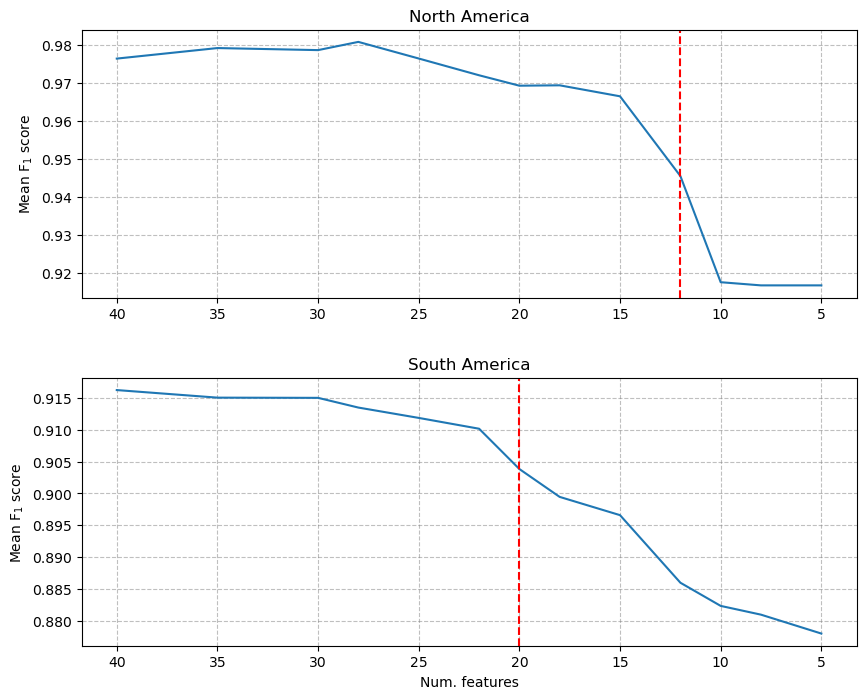

In [26]:
svm_axes = {}

fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"hspace": 0.3}, squeeze=False)
for ax, (region, svm_search_subset) in zip(np.ravel(axs), svm_search_regions.items()):
    svm_axes[region] = ax
    df_svm_subset = pd.concat(
        (
            pd.DataFrame(svm_search_subset.cv_results_["params"]),
            pd.DataFrame(
                {
                    key: svm_search_subset.cv_results_[key]
                    for key in (
                        "mean_test_score",
                        "std_test_score",
                    )
                }
            )
        ),
        axis="columns",
    )
    l = ax.plot(
        "featureagglomeration__n_clusters",
        "mean_test_score",
        data=df_svm_subset,
    )[0]
    l.set_label(None)

    ax.grid(
        linestyle="dashed",
        color="grey",
        alpha=0.5,
    )
    ax.set_xlim(*(ax.get_xlim()[::-1]))
    ax.set_title(region)

n_clusters_svm_regions = {
    "North America": 12,
    "South America": 20,
}
for region, n_clusters_region in n_clusters_svm_regions.items():
    ax = svm_axes[region]
    ax.axvline(
        n_clusters_region,
        linestyle="dashed",
        color="red",
        label="Optimal num. features",
    )

for ax in axs[:, 0]:
    ax.set_ylabel(r"Mean $\mathrm{F_1}$ score")
for ax in axs[-1, :]:
    ax.set_xlabel("Num. features")
fig.savefig(
    os.path.join(svm_figures_dir, "cv_results_regions.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Train models with chosen numbers of features

In [27]:
for region, n_clusters_region in n_clusters_svm_regions.items():
    r = "_".join(region.lower().split())
    output_subset = svm_basename + f"_{r}.joblib"

    if overwrite or (not os.path.isfile(output_subset)):
        subset_best = clone(svm_search_regions[region].best_estimator_)
        subset_best["featureagglomeration"].set_params(n_clusters=n_clusters_region)
        subset = combined[combined["region"] == region]
        subset = subset.drop(
            columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS),
            errors="ignore",
        )
        subset = subset[subset["label"].isin({"positive", "negative"})]
        x_svm_subset = subset.drop(columns="label")
        y_svm_subset = subset["label"].replace({"positive": 1, "negative": 0})
        subset_best.fit(x_svm_subset, y_svm_subset)
        svm_best_regions[region] = subset_best
        joblib.dump(subset_best, output_subset, compress=True)
    else:
        svm_best_regions[region] = joblib.load(output_subset)

#### Dendogram plots

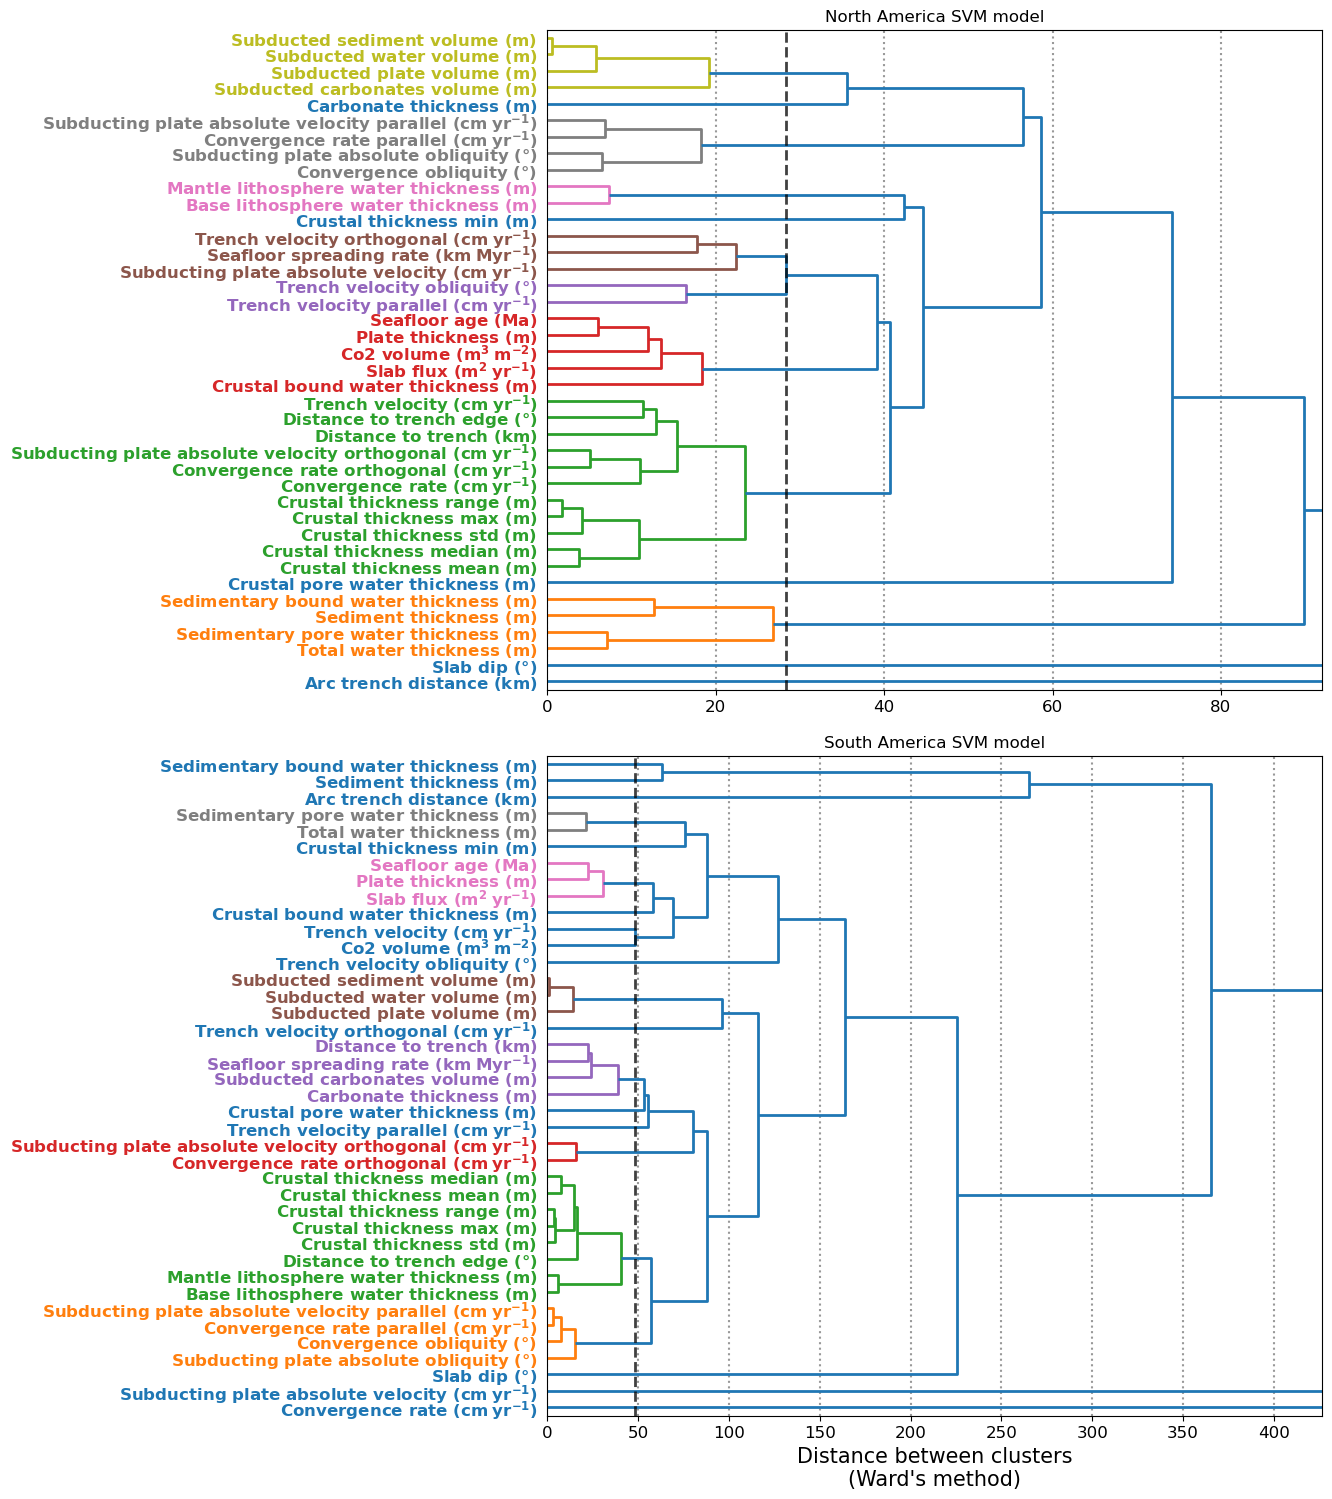

In [28]:
nrows = len(svm_best_regions)
fig, axs = plt.subplots(
    nrows,
    figsize=(10, 9 * nrows),
    gridspec_kw={"hspace": 0.1},
    squeeze=False,
)

for (region, svm_best_region), ax in zip(svm_best_regions.items(), np.ravel(axs)):
    agg_svm_region = svm_best_region["featureagglomeration"]
    dist_thresh_svm_region = agg_svm_region.distance_threshold
    if dist_thresh_svm_region is None:
        dist_thresh_svm_region = distance_threshold_from_model(agg_svm_region)

    dendro = dendrogram_from_model(
        agg_svm_region,
        orientation="right",
        color_threshold=dist_thresh_svm_region,
        ax=ax,
        labels=[format_feature_name(i, bold=True) for i in agg_svm_region.feature_names_in_],
    ).dendrogram
    ax.set_xlim(0, np.quantile(agg_svm_region.distances_, 0.95))
    ax.grid(
        linestyle="dotted",
        color="grey",
        alpha=0.8,
        linewidth=1.5,
        axis="x",
    )
    ax.axvline(
        dist_thresh_svm_region,
        linestyle="dashed",
        color="black",
        alpha=0.75,
        linewidth=2,
    )
    ax.tick_params(labelsize=12)
    ax.set_title(f"{region} SVM model")
    for coll in ax.collections:
        coll.set_linewidth(2)
    for i, j in zip(ax.get_ymajorticklabels(), dendro["leaves_color_list"]):
        i.set_color(j)
        i.set_fontweight("bold")
for ax in axs[-1, :]:
    ax.set_xlabel("Distance between clusters\n(Ward's method)", fontsize=15)
fig.savefig(
    os.path.join(svm_figures_dir, "dendrograms_regions.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Merged features

In [29]:
for region, svm_best_region in svm_best_regions.items():
    agg_svm_region = svm_best_region["featureagglomeration"]
    df_clusters_region = pd.DataFrame(
        {
            "cluster": agg_svm_region.labels_,
            "feature": agg_svm_region.feature_names_in_,
        }
    )
    print(f"{region}:")
    print("Merged features:")
    l = "-" * max([len(i) for i in df_clusters_region["feature"]])
    print(l)
    for cluster, subset in df_clusters_region.groupby("cluster"):
        if subset.shape[0] <= 1:
            continue
        for feature in sorted(subset["feature"]):
            print(feature)
        print(l)
    print("\n")

North America:
Merged features:
-----------------------------------------------------
seafloor_spreading_rate (km/Myr)
subducting_plate_absolute_velocity (cm/yr)
trench_velocity_obliquity (degrees)
trench_velocity_orthogonal (cm/yr)
trench_velocity_parallel (cm/yr)
-----------------------------------------------------
sediment_thickness (m)
sedimentary_bound_water_thickness (m)
sedimentary_pore_water_thickness (m)
total_water_thickness (m)
-----------------------------------------------------
subducted_carbonates_volume (m)
subducted_plate_volume (m)
subducted_sediment_volume (m)
subducted_water_volume (m)
-----------------------------------------------------
base_lithosphere_water_thickness (m)
mantle_lithosphere_water_thickness (m)
-----------------------------------------------------
convergence_rate (cm/yr)
convergence_rate_orthogonal (cm/yr)
crustal_thickness_max (m)
crustal_thickness_mean (m)
crustal_thickness_median (m)
crustal_thickness_range (m)
crustal_thickness_std (m)
dista